## Introduction to deep learning for medical imaging

### Tutorial 1. Classification of TB (Tuberculosis)  vs. NOT-TB (Not - Tuberculosis) in X-rays 

This is an introduction into practical deep learning application for medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between TB and NOT-TB X-rays. 

- Data is acquired from: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/TuberculosisChestXrayImageDataSets.html.

In this tutorial we download the two datasets from the above provided link and train a classifier based on montgomery dataset and check the generalization of the model on Shenzen dataset. Documentation for approach to download the datasets and setting up the folders is given under  

**Clink the badge above to launch this notebook on Google Colab.**
To use GPU, go to Edit -> Notebook settings -> Hardware accelerator (GPU)

### Install all the required frameworks

In [ ]:
!pip install pandas
!pip install tensorflow 
!pip install SimpleITK
!pip install scikit-learn
!pip install pydicom
!pip install segmentation_models
!pip install scikit-image

     |████████████████████████████████| 462 kB 36.1 MB/s 
     |████████████████████████████████| 48.4 MB 1.2 MB/s 
     |████████████████████████████████| 2.0 MB 33.6 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 


### Import all the required framework for the analysis

In [ ]:
import glob
import os
import pandas as pd
import cv2
import numpy as np
import pydicom
import zipfile
import SimpleITK as sitk
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage import exposure
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
import multiprocessing
from functools import partial
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

Segmentation Models: using `keras` framework.


### Mount your Google drive and set up the root directory. 

In [ ]:
from google.colab import drive
import requests

drive.mount("/content/drive")

# Set up the root directory
root_dir = '/content/drive/MyDrive/niehs_tutorials'

Mounted at /content/drive


### Download the datasets (User can follow either of the options ).

####Option 1:
Manually download the datasets(.zip files) by opening the provided link in the Introduction and click on the 'Download link' option.  After unzipping them in your local computer, you can upload the two directories('MontgomerySet' and 'ChinaSet_AllFiles') in the root directory(In this case, root_dir = '/content/drive/MyDrive/niehs_tutorials'). If user is facing any problem in downloading the datasets, they can right click on the 'Download link' option and copy the link address to paste in a new tab of your browser. 

####Option 2:
Run the below cell. Below pythonic code will download the datasets and unzips the folders under the root directory. This code snippet would take much more time to setup than option 1.

In [ ]:
# Don't have to run
montgomery_county_dataset_download_url = 'http://openi.nlm.nih.gov/imgs/collections/NLM-MontgomeryCXRSet.zip'
shenzen_county_dataset_download_url = 'http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip'

r1 = requests.get(montgomery_county_dataset_download_url, allow_redirects=True)
open(os.path.join(root_dir,'montgomerycounty_data.zip'), 'wb+').write(r1.content)

r2 = requests.get(montgomery_county_dataset_download_url, allow_redirects=True)
open(os.path.join(root_dir,'shenzen_data.zip'), 'wb+').write(r2.content)


## Unzip the files
with zipfile.ZipFile(os.path.join(root_dir,'montgomerycounty_data.zip'), 'r') as zip_ref:
    zip_ref.extractall(root_dir)
with zipfile.ZipFile(os.path.join(root_dir,'shenzen_data.zip'), 'r') as zip_ref:
    zip_ref.extractall(root_dir)

## Remove the zip files as we don't need them anymore
os.remove(os.path.join(root_dir,'montgomerycounty_data.zip'))
os.remove(os.path.join(root_dir,'shenzen_data.zip'))

### Grab the CXRs and labels

In this analysis we use shenzen dataset for model development . Label '0' indicates that the patient is not infected with tuberculosis and Label '1' indicates that patient is infected with tuberculosis

In [4]:
#Don't have to run
shenzen_cxrs = glob.glob(os.path.join(root_dir,'ChinaSet_AllFiles','CXR_png','*.png'))
shenzen_tb_cxrs = glob.glob(os.path.join(root_dir,'ChinaSet_AllFiles','CXR_png','*_1.png'))
shenzen_not_tb_cxrs = glob.glob(os.path.join(root_dir,'ChinaSet_AllFiles','CXR_png','*_0.png'))
shenzen_labels = [int(os.path.splitext(cxr_file)[0].split('_')[-1]) for cxr_file in shenzen_cxrs]

### Display few random images of varying sizes

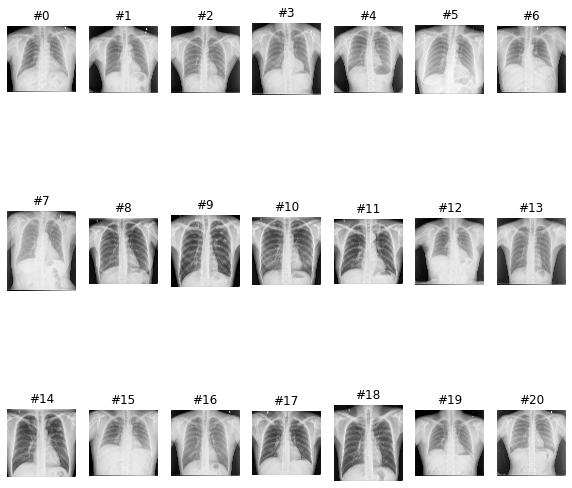

In [5]:
#Don't have to run
NUM_SAMPLES = 21
fig_rows = 3
fig_columns = 7

plt.rcParams["figure.figsize"]=10,10
_,subfigs = plt.subplots(fig_rows, fig_columns)
k = 0
for row in range(fig_rows):
  for column in range(fig_columns):
      img = sitk.ReadImage(shenzen_cxrs[k])
      arr = sitk.GetArrayFromImage(img)       
      subfigs[row,column].imshow(arr, cmap = 'gray')
      subfigs[row,column].set_title('#'+str(k))
      subfigs[row,column].axis('off')
      k = k+1
plt.show()

### Preprocess the CXRs

In this step, we use a lung segmentation model, to detect the lung regions in the CXRs and crop the bounding box of the CXR around the lungs. In this analysis, we will use a pretrained lung segmentation model, trained on nearly 6000 covid containing patient CXRs. Dataset to train for this model has been acquired from https://github.com/v7labs/covid-19-xray-dataset

Resample all input images to (256,256) before feeding to lung segmentation model

In [6]:
#Don't have to run
def _srgb2gray(image):
    # Convert sRGB image to gray scale and rescale results to [0,255]    
    channels = [sitk.VectorIndexSelectionCast(image,i, sitk.sitkFloat32) for i in range(image.GetNumberOfComponentsPerPixel())]
    #linear mapping
    I = 1/255.0*(0.2126*channels[0] + 0.7152*channels[1] + 0.0722*channels[2])
    #nonlinear gamma correction
    I = I*sitk.Cast(I<=0.0031308,sitk.sitkFloat32)*12.92 + I**(1/2.4)*sitk.Cast(I>0.0031308,sitk.sitkFloat32)*1.055-0.55
    return sitk.Cast(sitk.RescaleIntensity(I), sitk.sitkUInt8)


def _resample_cxr_for_lung_segmentation_cnn(new_size, gaussian_sigma, file):
    """
    Downsample the input image to the given new_size. To avoid aliasing artifacts
    you may want to blur the image before the downsampling operation. This is important
    if your image contains high frequency data.
    Args:
        new_size: The size of the resampled image in pixels.
        gaussian_sigma(scalar or tuple with image dimension length): If given,
               blur the image with a Gaussian with the given standard deviation(s)
               before resampling.
        file (str): File path to image we want to resample.
    Returns:
        Tuple (SimpleITK.Image, SimpleITK.Image): Original image and it's normalized resampled image.
        """
    print("Resampling ..." + file + " to lung segmentation model input size")
    original_image = sitk.ReadImage(file)

    # Some images are grayscale but the channel is repeated three times (gray RGB image).
    if original_image.GetNumberOfComponentsPerPixel() > 1:
        original_image = _srgb2gray(original_image)
    new_spacing = [sz * spc / nsz for nsz, sz, spc in
                   zip(new_size, original_image.GetSize(), original_image.GetSpacing())]
    smoothed_image = sitk.SmoothingRecursiveGaussian(original_image, gaussian_sigma)
    resampled_for_seg = sitk.Resample(smoothed_image, new_size, sitk.Transform(), sitk.sitkLinear,
                                      original_image.GetOrigin(), new_spacing, original_image.GetDirection(),
                                      0, sitk.sitkFloat32)
    return original_image, resampled_for_seg

Load the lung segmentation model and predict the lung masks on the resampled images.

In [7]:
#Don't have to run
def load_seg_model(path):
    """
    We load the segmentation model using this function

    Args:
        path (string): Model path for segmentation model

    Returns:
        model(tf.keras.model): Loaded model
    """
    model = sm.Unet('resnet50',  encoder_freeze=True)
    model.compile(optimizer='Adam',
                 loss=sm.losses.bce_jaccard_loss,
                 metrics=[sm.metrics.iou_score])
    model.load_weights(path)
    return model

def _predict_mask(resampled_image_arr, model_path, batch_size=10):
    """
    Predict the lung mask from the resampled image array. This uses segmentation
    model to segment lungs for a given image with size equal to model input size.

    Args:
        resampled_image_arr (numpy array): Numpy array obtained from resampled images
                                           to provide input for segmentation network in the
                                           shape of (num_images,segmentation_input_size_x,
                                           segmentation_input_size_y)
        model_path: File path of the trained model(UNet)
        batch_size: Batch size for the model. Performing inference in batch mode is faster than
                    image by image.
    Returns:
        Numpy array: Prediction masks of segmented lungs with same size as input array.
    """
    print("Predicting lung segmentation regions ....")
    model = load_seg_model(model_path)
    pred = model.predict(resampled_image_arr, batch_size=batch_size, verbose=0).reshape(resampled_image_arr.shape[0:3])
    pr = pred > 0.5

    return pr.astype(int)


After lung masks are obtained, we use that mask to crop the bounding box containing lung regions from the original CXRs.

In [ ]:
#Don't have to run
def _segmented_lung_2_tb_cnn(new_size, resampled_image, np_lung_segmentation_mask,
                             original_image, gaussian_sigma):
    """
    Resample a subregion of a given image based on a mask.
    Args:
       original_image (SimpleITK.Image): Original Image
       resampled_image (SimpleITK.Image): Image that was resampled to create sitk_lung_segmentation_image.
                                         Both images occupy the same physical space, but they differ in
                                         size (pixel count) and spacing.
       np_lung_segmentation_mask (numpy.array): Array denoting segmentation mask.
                                                Array size matches the sitk_lung_segmentation_image
                                                image size.
       new_size (list like): The region in the original_image defined by the segmentation mask is resampled
                             to this size.
       gaussian_sigma(scalar or tuple with image dimension length): If given,
               blur the image with a Gaussian with the given standard deviation(s)
               before resampling.
    Returns:
        SimpleITK.Image and Confidence: Returns the lung segmented region in the
                                        original image which is resampled to the
                                        given size and returns segmentation confidence
                                        if the segmentation process of the CXR
                                        was done well.

    """
    lung_labels = [1, 2]
    segmentation_image = sitk.GetImageFromArray(np_lung_segmentation_mask)
    segmentation_image.CopyInformation(resampled_image)
    # relabel the segmentation so that the labels 1, and 2 correspond to the largest
    # components, assumed to be the lungs
    disjointed_segmentation_image = sitk.RelabelComponent(sitk.ConnectedComponent(segmentation_image),
                                                          sortByObjectSize=True)
    if gaussian_sigma:
        original_image = sitk.SmoothingRecursiveGaussian(original_image, gaussian_sigma)
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute(disjointed_segmentation_image)
    # Assign segmentation confidence variable to 'High' whenever segmentation process
    # "succeeds" and 'Low' whenever segmentation process fails
    seg_confidence = 'High'
    perimeter_threshold = 600  # For successful segmentation of lungs
    try:
        # Some of the images which are successfully segmented do not contain lungs
        # in the images.So we threshold the perimeter of the 2 lung regions.Area
        # is not taken as a measure becuase some of the successfully segmented images
        # have a major area  difference. E.g: 'CHNCXR_0361_1.png'(Due to the existence
        # of large airspaces in the lungs). So area is not taken as a measure for
        # filtering out the "non-lung" containing images
        perimeter_left = label_shape_filter.GetPerimeter(lung_labels[0])
        perimeter_right = label_shape_filter.GetPerimeter(lung_labels[1])
        if not (perimeter_left > perimeter_threshold and perimeter_right > perimeter_threshold):  # Threshold
            np_lung_segmentation_mask = np.ones(resampled_image.GetSize(), dtype=np.int64)
            seg_confidence = 'Low'
    except:
        # Some predicted masks contain no lung masks(no '1's in 'np_lung_segmentation_mask' array)
        # Assigning lung predicted masks to all ones would essentially select all the
        # area of the original image in the end
        np_lung_segmentation_mask = np.ones(resampled_image.GetSize(), dtype=np.int64)
        seg_confidence = 'Low'

    # Replace all the noise objects(apart from 2 lung regions) with zeros
    noise_labels = [x for x in label_shape_filter.GetLabels() if x not in lung_labels]
    for ns_label in noise_labels:
        ns_bb = label_shape_filter.GetBoundingBox(ns_label)
        np_lung_segmentation_mask[ns_bb[1]:ns_bb[1] + ns_bb[3], ns_bb[0]:ns_bb[0] + ns_bb[2]] = np.zeros(
            (ns_bb[3], ns_bb[2]))
    segmentation_image = sitk.GetImageFromArray(np_lung_segmentation_mask)
    segmentation_image.CopyInformation(resampled_image)
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute(segmentation_image)
    # The bounding box's first two entries are the starting index and last 
    # two entries the size
    bounding_box = label_shape_filter.GetBoundingBox(lung_labels[0])
    new_origin = segmentation_image.TransformIndexToPhysicalPoint(bounding_box[0:2])
    new_spacing = [(sz - 1) * spc / (new_sz - 1) for sz, spc, new_sz in
                   zip(bounding_box[2:4], segmentation_image.GetSpacing(), new_size)]
    arr = sitk.GetArrayFromImage(sitk.Resample(original_image, new_size, sitk.Transform(), sitk.sitkLinear,
                                               new_origin, new_spacing, original_image.GetDirection(),
                                               0))
    arr = (arr - np.mean(arr)) / np.std(arr)
    return np.reshape(arr, arr.shape + (1,))

Below snippet code can be used to generate final segmentation array containing cropped image array for all the input files

In [9]:
#Don't have to run
def _standardize_input(img):
    '''
    Standardize input image with minimum value = 0 and maximum value = 1
 
    Args:
        img(sitk.Image):  Input image

    Returns:
        arr(numpy.array): Output standardized array
        '''   
      arr = sitk.GetArrayFromImage(img)
      arr = arr - np.min(arr)
      arr = arr / np.max(arr)
      arr = exposure.equalize_adapthist(arr) 
      return arr
        
def _gen_seg_image_arr(files,model_path,model_input_size,batch_size,required_output_img_size,gaussian_sigma):
    '''
    Generate an array from lung segmented images.This process happens in 3 stages:
    1.) Reading and Resampling of original images
    2.) Predict masks from the array of resampled image array
    3.) Segment lungs from the original images using the predicted masks 
    
    Args:
        files(list):  List of CXR filepaths
        model_path(string): path for trained model.
        model_input_size(tuple): size required as model input
        batch_size(int): batch size for segmentation algorithm to predict
        required_output_img_size: required output image size for building tb/not-tb model
        gaussian_sigma(scalar or tuple with image dimension length): If given, 
               blur the image with a Gaussian with the given standard deviation(s)
               before resampling.
    Returns:
        list of numpy array: array extracted from segmented images
        '''   

    resampled_imgs = np.ndarray((len(files),),dtype=np.object)
    original_imgs = np.ndarray((len(files),),dtype=np.object)

    #Read and resample original images to segmentation algo. size 

    returned_imgs = [_resample_cxr_for_lung_segmentation_cnn(model_input_size, gaussian_sigma,file) for file in files]

    print("Resampling of all images done")      

    original_imgs, resampled_imgs= zip(*returned_imgs)               
    #Extract array from each resampled image
    resampled_img_arr = np.asarray(list(map(lambda img:_standardize_input(img), resampled_imgs)))   

    #Reshape the array to fit into model input size
    resampled_img_arr = np.reshape(resampled_img_arr,resampled_img_arr.shape+(1,)) 
    resampled_img_arr = np.stack((resampled_img_arr, resampled_img_arr, resampled_img_arr), axis=3)

    #Predict Images
    pred_masks = _predict_mask(resampled_img_arr,model_path,batch_size)

    print("Segmentation of lungs in CXRs done..")
    #Segment Lungs from Original Images
    func = partial(_segmented_lung_2_tb_cnn,required_output_img_size)

    final_images_list = []
    i = 0
    for r,p,o in zip(resampled_imgs,pred_masks, original_imgs):
        print("Cropping lung regions in "+ files[i])
        final_images_list.append(func(r, p, o, gaussian_sigma))
        i = i+1

    print("Cropping done.")
       
    return final_images_list

IndentationError: ignored

Until the above step, we defined all the preprocessing functions for preprocessing. We will now execute the function which will accept the files that we use for classification analysis, predicts lung regions on them and crops those regions "only" to contain bounding box area of lungs.

In [ ]:
#Don't have to run
lung_segment_model_path = os.path.join(root_dir,'lung_segment_model.h5')
lung_segment_model_input_size=(256,256)
batch_size=8
required_output_img_size=(224,224)
gaussian_sigma=0.5

data_bounding_box_lung_list = _gen_seg_image_arr(combined_balanced_samples,lung_segment_model_path,lung_segment_model_input_size,batch_size,required_output_img_size,gaussian_sigma)


### Display cropped images

In [ ]:
#Don't have to run
plt.rcParams["figure.figsize"]=8,8
fig_rows = 3
fig_columns = 5
_,subfigs = plt.subplots(fig_rows, fig_columns)
k = 0
for row in range(fig_rows):
  for column in range(fig_columns):     
      arr = data_bounding_box_lung_list[k][:,:,0]
      arr = arr - np.min(arr)
      arr = arr / np.max(arr)
      arr = arr*255
      arr = arr.astype(int)
      subfigs[row,column].imshow(arr, cmap = 'gray')
      subfigs[row,column].set_title('#'+str(k))
      subfigs[row,column].axis('off')
      k = k+1
plt.show()

### Divide training and validation

In [ ]:
#Don't have to run
num_tb_samples = sum(shenzen_labels)
num_not_tb_samples = len(shenzen_labels) - num_tb_samples
print("TB samples :" + str(num_tb_samples) + ", NOT-TB samples:"+str( num_not_tb_samples)) #336,326

# Select random 326 tb images to balance the dataset
np.random.seed(42)
balanced_tb_samples_idxs = np.random.choice(num_tb_samples,num_not_tb_samples,replace=False)
balanced_tb_samples = [shenzen_tb_cxrs[idx] for idx in balanced_tb_samples_idxs]

combined_balanced_samples = balanced_tb_samples + shenzen_not_tb_cxrs 
combined_balanced_labels = np.asarray([1]*len(balanced_tb_samples)+[0]*len(shenzen_not_tb_cxrs))
print("Combined balanced samples :"+str(len(combined_balanced_samples)))

X_train_val_indices, X_test_indices, y_train_val, y_test = train_test_split(range(len(combined_balanced_samples)), combined_balanced_labels, test_size=0.2, random_state=42,stratify=combined_balanced_labels)
X_train_indices, X_val_indices, y_train, y_val = train_test_split(X_train_val_indices, y_train_val, test_size=0.2, random_state=4,stratify=y_train_val)

#Train-64%, Val-16%, Test-20%
print("Train samples :"+str(len(X_train_indices)) + ", Val samples :"+str(len(X_val_indices)) + ", Test samples :" +str(len(X_test_indices)))

###Prepare input for training TB vs NOT-TB model

In [ ]:
#Don't have to run
train_bounding_box_lung_arr = np.asarray([data_bounding_box_lung_list[idx] for idx in X_train_indices])
val_bounding_box_lung_arr = np.asarray([data_bounding_box_lung_list[idx] for idx in X_val_indices])
test_bounding_box_lung_arr = np.asarray([data_bounding_box_lung_list[idx] for idx in X_test_indices])

train_bounding_box_lung_arr = np.repeat(train_bounding_box_lung_arr,repeats=3,axis=3)
val_bounding_box_lung_arr = np.repeat(val_bounding_box_lung_arr,repeats=3,axis=3)
test_bounding_box_lung_arr = np.repeat(test_bounding_box_lung_arr,repeats=3,axis=3)

print(train_bounding_box_lung_arr.shape)
print(val_bounding_box_lung_arr.shape)
print(test_bounding_box_lung_arr.shape)

np.savez(os.path.join(root_dir,'shenzen_train_data.npz'),train_bounding_box_lung_arr,y_train)
np.savez(os.path.join(root_dir,'shenzen_val_data.npz'),val_bounding_box_lung_arr,y_val)
np.savez(os.path.join(root_dir,'shenzen_test_data.npz'),test_bounding_box_lung_arr,y_test)      

In [10]:
#Run the cells from here
shenzen_train = np.load(os.path.join(root_dir,'shenzen_train_data.npz'))
shenzen_val = np.load(os.path.join(root_dir,'shenzen_val_data.npz'))
shenzen_test = np.load(os.path.join(root_dir,'shenzen_test_data.npz'))

train_bounding_box_lung_arr,y_train = shenzen_train['arr_0'],shenzen_train['arr_1']
val_bounding_box_lung_arr,y_val = shenzen_val['arr_0'],shenzen_val['arr_1']
test_bounding_box_lung_arr,y_test = shenzen_test['arr_0'],shenzen_test['arr_1']



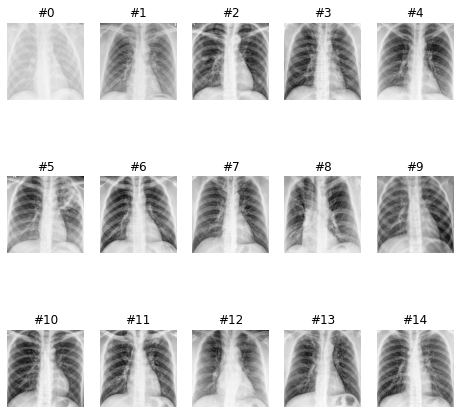

In [12]:
#Run the cells from here
plt.rcParams["figure.figsize"]=8,8
fig_rows = 3
fig_columns = 5
_,subfigs = plt.subplots(fig_rows, fig_columns)
k = 0
for row in range(fig_rows):
  for column in range(fig_columns):     
      arr = train_bounding_box_lung_arr[k,:,:,0]
      arr = arr - np.min(arr)
      arr = arr / np.max(arr)
      arr = arr*255
      arr = arr.astype(int)
      subfigs[row,column].imshow(arr, cmap = 'gray')
      subfigs[row,column].set_title('#'+str(k))
      subfigs[row,column].axis('off')
      k = k+1
plt.show()

### Use tf.keras for training and validation

On Colab run the following %tensorflow_version line magic function to set tensorflow to v2.

In [13]:
#Run the cells from here
%tensorflow_version 2.x

In [14]:
print(tf.__version__)
tf.keras.backend.clear_session()

2.8.0


Prepare Training settings

In [16]:
#Run the cells from here
# Define model parameters 
img_width = 224
img_height = 224
epochs = 100
batch_size=8

### User can choose any pretrained model(DenseNet121, VGG16 etc.) or custom model to start their training with. We choose DenseNet121 because it is a lightweight architecture which works well with small datasets.

In [ ]:
#Run the cells from here
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, 
                                             input_shape=(img_width, img_height, 3))

output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output), 

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

### Train the model

In [18]:
#Run the cells from here
# Callbacks to stop early and save model periodically
model_output_filename = os.path.join(root_dir,'best_tb_not_tb_model.h5')
earlystopper = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
modelSaver = ModelCheckpoint(model_output_filename, monitor='val_loss', verbose=0,
                              save_best_only=True,
                              save_weights_only=False, mode='auto', save_freq='epoch')

# set optimization params and compile
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_bounding_box_lung_arr)
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(train_bounding_box_lung_arr, y_train, batch_size=batch_size), 
                    epochs=epochs, # one forward/backward pass of training data
                    steps_per_epoch=train_bounding_box_lung_arr.shape[0]//batch_size, # number of images comprising of one epoch
                    validation_data=(val_bounding_box_lung_arr, y_val), # data for validation
                    callbacks=[earlystopper,modelSaver])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
52/52 [==============================] - 38s 292ms/step - loss: 0.5342 - accuracy: 0.7500 - val_loss: 0.4885 - val_accuracy: 0.7048
Epoch 2/100
52/52 [==============================] - 10s 181ms/step - loss: 0.4833 - accuracy: 0.7764 - val_loss: 0.4366 - val_accuracy: 0.7524
Epoch 3/100
52/52 [==============================] - 9s 181ms/step - loss: 0.4478 - accuracy: 0.8005 - val_loss: 0.3755 - val_accuracy: 0.8286
Epoch 4/100
52/52 [==============================] - 7s 128ms/step - loss: 0.3299 - accuracy: 0.8534 - val_loss: 0.4629 - val_accuracy: 0.7905
Epoch 5/100
52/52 [==============================] - 7s 130ms/step - loss: 0.3874 - accuracy: 0.8438 - val_loss: 0.8471 - val_accuracy: 0.6095
Epoch 6/100
52/52 [==============================] - 7s 128ms/step - loss: 0.3064 - accuracy: 0.8582 - val_loss: 0.8726 - val_accuracy: 0.7048
Epoch 7/100
52/52 [==============================] - 10s 201ms/step - loss: 0.2504 - accuracy: 0.9038 - val_loss: 0.3128 - val_accuracy: 0.8

KeyboardInterrupt: ignored

### Test the model

In [19]:
#Run the cells from here
model_output_filename = os.path.join(root_dir,'best_tb_not_tb_model.h5')
model = tf.keras.models.load_model(model_output_filename)
y_pred = model.predict(test_bounding_box_lung_arr)  
y_pred = np.squeeze(y_pred)

# User can change the threshold
threshold=0.5
y_pred =  y_pred > threshold 
# performance metric calculation
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(metrics.confusion_matrix(y_test, y_pred))
cl_report = metrics.classification_report(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

precision, recall, thresholds = metrics.precision_recall_curve( y_test, y_pred)
precision_recall_auc = metrics.auc(recall,precision )
# print to screen
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print('F1 Score: ' + str(f1))
print("Accuracy: " + str(accuracy))
print("ROC AUC :" + str(roc_auc))    
print("Precision Recall AUC: " + str(precision_recall_auc))                                       

[[55 11]
 [ 7 58]]
Recall: [1.         0.89230769 0.        ]
Precision: [0.49618321 0.84057971 1.        ]
F1 Score: 0.8656716417910447
Accuracy: 0.8625954198473282
ROC AUC :0.8628205128205128
Precision Recall AUC: 0.8931612584782183


After evaluating the model on test set, consider Montgomery county dataset as another test set and test your model on that to verify how "generalizable" your model is. To prepare the test set for Shenzen dataset, one can follow the same preprocessing steps as discussed above.

In [ ]:
#Don't have to run
mont_cxrs = glob.glob(os.path.join(root_dir,'MontgomerySet','CXR_png','*.png'))
mont_tb_cxrs = glob.glob(os.path.join(root_dir,'MontgomerySet','CXR_png','*_1.png'))
mont_not_tb_cxrs = glob.glob(os.path.join(root_dir,'MontgomerySet','CXR_png','*_0.png'))
mont_labels = [int(os.path.splitext(cxr_file)[0].split('_')[-1]) for cxr_file in mont_cxrs]

### Generate cropped lung data for Montgomery County CXRs

In [ ]:
#Don't have to run
montgomery_county_data_bounding_box_lung_list = _gen_seg_image_arr(mont_cxrs,lung_segment_model_path,lung_segment_model_input_size,batch_size,required_output_img_size,gaussian_sigma)


In [ ]:
#Don't have to run
montgomery_county_data_bounding_box_lung_arr = np.asarray(montgomery_county_data_bounding_box_lung_list)

montgomery_county_data_bounding_box_lung_arr = np.repeat(montgomery_county_data_bounding_box_lung_arr,repeats=3,axis=3) 

np.savez(os.path.join(root_dir,'cropped_mont_data.npz'),montgomery_county_data_bounding_box_lung_arr,mont_labels)

### Predict on Montgomery County dataset using the trained model on Shenzen dataset to check for generalization

In [22]:
#Run the cells from here
model_output_filename = os.path.join(root_dir,'best_tb_not_tb_model.h5')
model = tf.keras.models.load_model(model_output_filename)
mont_data = np.load(os.path.join(root_dir,'cropped_mont_data.npz'))
montgomery_county_data_bounding_box_lung_arr,mont_labels = mont_data['arr_0'],mont_data['arr_1']

mont_y_pred = model.predict(montgomery_county_data_bounding_box_lung_arr)  
mont_y_pred = np.squeeze(mont_y_pred)


###We calculate AUC under precision recall curve as the classes between TB and NOT-TB are imbalanced in Montgomery County dataset

In [23]:
#Run the cells from here
precision, recall, _ = metrics.precision_recall_curve(mont_labels, mont_y_pred)

precision_recall_auc_on_mont = metrics.auc(recall, precision)

print("Precision Recall AUC on Montgomery County dataset: " + str(precision_recall_auc_on_mont)) 

Precision Recall AUC on Montgomery County dataset: 0.7756030559534052


From the above AUC value, we can see that the trained model has not generalized well. I would encourage each one of you to try different pretrained network architectures with various layers and various hyperparameters and see if you can increase not only the performance of test data  (AUC of precision - recall curve)  but also the performance on the Montgomery County dataset as well.